# Setup

In [450]:
import numpy as np
from matplotlib import pyplot as plt
import os, sys
import nd2
import cv2 as cv
import pandas as pd
import matplotlib.patches as patches
from scipy.optimize import basinhopping, minimize

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from data import config
from data.data import Data, load_datasets

config.ROOT_PATH = os.path.abspath(os.path.join('..'))

In [232]:
# Indecies for subsample of dataset to perform testing on
# Looking at 100 droplets RANDOMLY selected from the dataset
columns, rows = 10, 10 # can be changed to vary the number of droplets being investigated

np.random.seed(42) # set the seed

# Just to get the length of the dataset
dataset = Data()
labels = dataset.labels[:,1]
idxs = np.random.randint(1, len(dataset), 100)

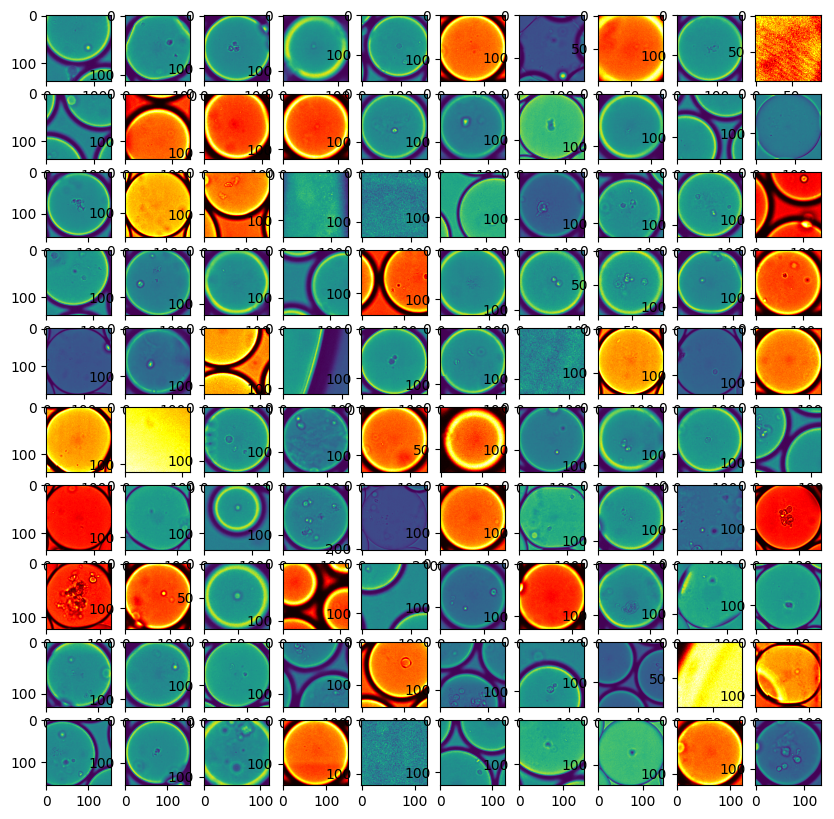

In [233]:
#plot samples
fig = plt.figure(figsize=(10, 10))
fig_index = 1
for idx in idxs:
    img = np.load(f'{config.ROOT_PATH}/data/clean/img{idx}.npy')
    fig.add_subplot(rows, columns, fig_index)
    fig_index += 1
    if labels[idx] == 0:
        color_map = 'hot'
    else:
        color_map = 'viridis'
    plt.imshow(img[img.shape[0]-1,:,:], cmap=color_map)
plt.show()

# Edge --> Circle Criterion Filtering

In [234]:
def plot_circles(feature_circles, colors, padding = 10, plot=False, fname='defaultname.png'):
    plt.figure(figsize = (len(mask[0]), len(mask[1])))

    fig, ax = plt.subplots()

    for i in range(len(feature_circles)):
        patch = patches.Circle( feature_circles[i][0], feature_circles[i][1] + padding, linewidth=1, edgecolor=colors[i], facecolor='none')
        ax.add_patch(patch)

    plt.imshow(test)
    if plot:
        plt.savefig(fname)
    plt.show()

In [235]:
# Test circle detection on entire sample [NOTE: This takes a very long time!!!!]
'''
sample_idx = 4

img = nd2.imread(dataset.sample_list[sample_idx]['img_path'])


# Preprocess image for cv2
gs_image = img[img.shape[0]-1,:,:]
max_val = gs_image.max()
gs_image = (gs_image / gs_image.max()) * 255
gs_image = np.array(gs_image, dtype = np.uint8)


fig, ax = plt.subplots(figsize=(10, 10))


circles = cv.HoughCircles(gs_image, cv.HOUGH_GRADIENT, 1, rows / 8,
                               param1=100, param2=30,
                               minRadius=1, maxRadius=500)[0]


for i in range(len(circles)):
    patch = patches.Circle( circles[i][:2], circles[i][2], linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(patch)


plt.title('Sample = ' + dataset.sample_list[sample_idx]['name'])
plt.imshow(a)
'''


"\nsample_idx = 4\n\nimg = nd2.imread(dataset.sample_list[sample_idx]['img_path'])\n\n\n# Preprocess image for cv2\ngs_image = img[img.shape[0]-1,:,:]\nmax_val = gs_image.max()\ngs_image = (gs_image / gs_image.max()) * 255\ngs_image = np.array(gs_image, dtype = np.uint8)\n\n\nfig, ax = plt.subplots(figsize=(10, 10))\n\n\ncircles = cv.HoughCircles(gs_image, cv.HOUGH_GRADIENT, 1, rows / 8,\n                               param1=100, param2=30,\n                               minRadius=1, maxRadius=500)[0]\n\n\nfor i in range(len(circles)):\n    patch = patches.Circle( circles[i][:2], circles[i][2], linewidth=1, edgecolor='red', facecolor='none')\n    ax.add_patch(patch)\n\n\nplt.title('Sample = ' + dataset.sample_list[sample_idx]['name'])\nplt.imshow(a)\n"

In [236]:
# Resample Dataset
idxs = np.random.randint(1, len(dataset), 100)

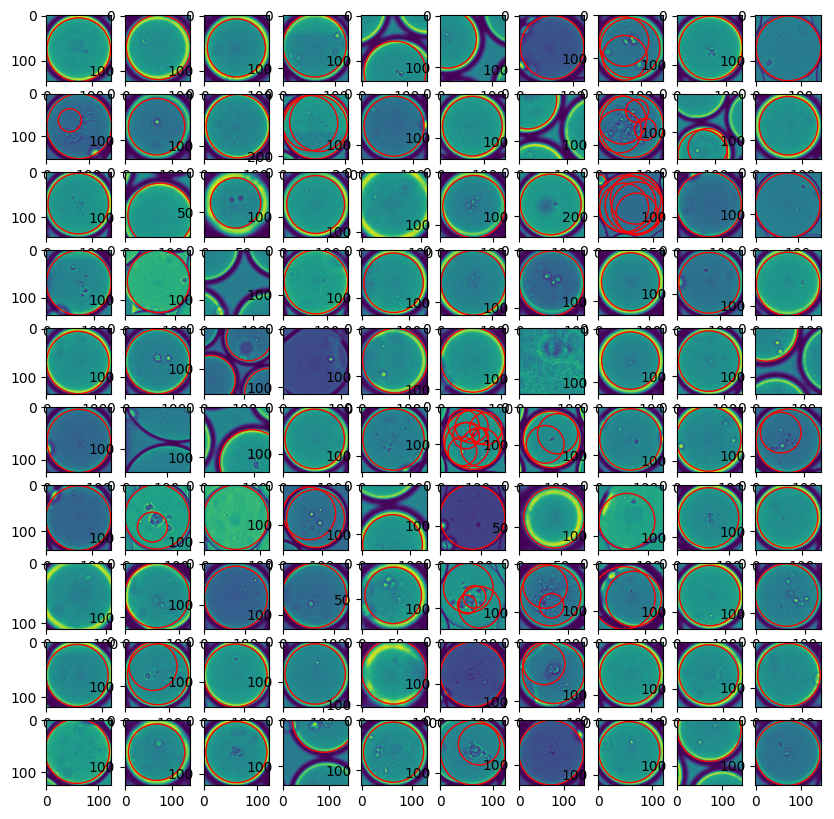

In [237]:
#plot samples
fig = plt.figure(figsize=(10, 10))
fig_index = 1
for idx in idxs:
    img = np.load(f'{config.ROOT_PATH}/data/clean/img{idx}.npy')
    img = img[img.shape[0]-1,:,:]
    
    # Put in openCV format
    img = (img / img.max()) * 255
    img = np.array(img, dtype = np.uint8)
    
    # Find circles
    circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, 1, 20,
                               param1=120, param2=30,
                               minRadius=20, maxRadius=img.shape[0]//2)
    if circles is None:
        circles = []
    else:
        circles = circles[0]

    #print(len(circles))
    
    ax = fig.add_subplot(rows, columns, fig_index)
    fig_index += 1
    circ_plots = []
    
    for circ in circles:
        circ_plot = plt.Circle(circ[:2], circ[2], color='r', fill=False)
        ax.add_patch( circ_plot )
        
    plt.imshow(img, cmap='viridis')
plt.show()

In [238]:
def check_droplet(det_circle, true_circle, pct=0.1):
    '''
    Similarity metric for detected circles and actual droplet
    
    Both arguments in (x, y, r) format
    
    pct -- maximum deviation as fraction of true metrics
    
    Return true if any of circles are good
    '''
    # Check center
    offset_from_origin = ((true_circle['r']-det_circle[0])**2 + (true_circle['r']-det_circle[1])**2)**0.5
    check_origin = offset_from_origin <= pct*true_circle['r']
    check_r = (1 - pct)*true_circle['r'] <= det_circle[2] <= (1 + pct)*true_circle['r']
    
    return check_r and check_origin
    

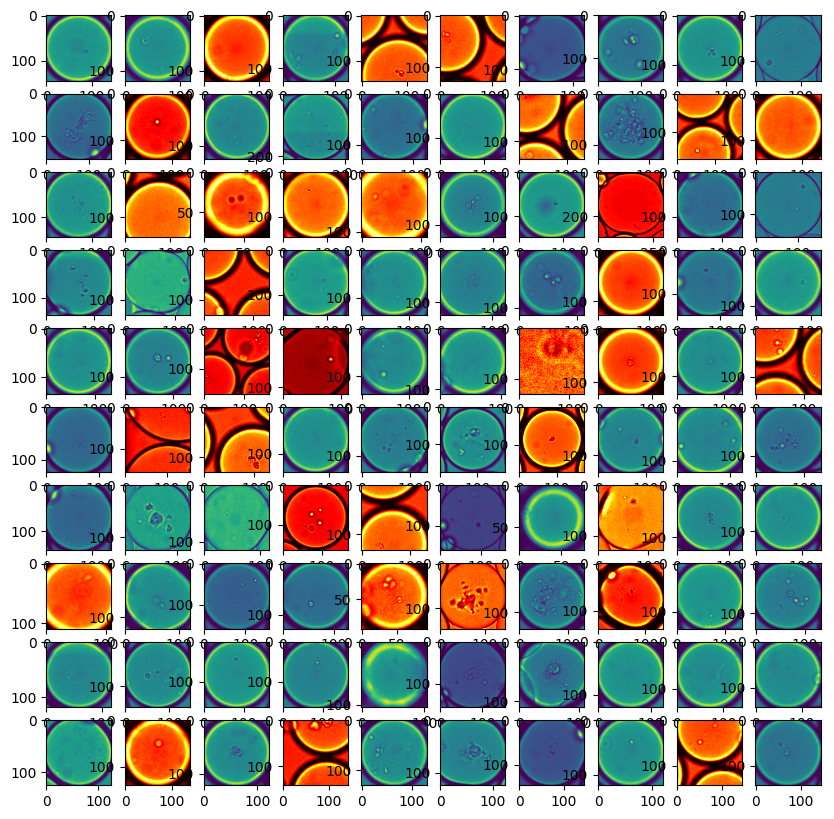

In [239]:
#plot samples
fig = plt.figure(figsize=(10, 10))
fig_index = 1
for idx in idxs:
    img = np.load(f'{config.ROOT_PATH}/data/clean/img{idx}.npy')
    img = img[img.shape[0]-1,:,:]
    
    # Put in openCV format
    img = (img / img.max()) * 255
    img = np.array(img, dtype = np.uint8)
    
    # Find circles
    circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, 1, 20,
                               param1=120, param2=30,
                               minRadius=20, maxRadius=img.shape[0]//2)
    if circles is None:
        circles = []
    else:
        circles = circles[0]

    #print(len(circles))
    
    ax = fig.add_subplot(rows, columns, fig_index)
    fig_index += 1
    circ_plots = []
    
    samp_ok = False
    for circ in circles:
        samp_ok = samp_ok or check_droplet(circ, dataset.droplet_list[idx])
        # Check if size is legit
    
    if samp_ok:
        cmap = 'viridis'
    else:
        cmap = 'hot'
    plt.imshow(img, cmap=cmap)
plt.show()

## Optimize

In [430]:
# Load in the manually labelled data by each of Louis Mattis and Haruki

louis_truth = pd.read_csv('../data/outliers/LabelledOutliers_600_Louis.csv')
matis_truth = pd.read_csv('../data/outliers/LabelledOutliers_600_Matis.csv')
haruki_truth = pd.read_csv('../data/outliers/LabelledOutliers_600_Haruki.csv')

assert( not a.equals(b) or b.equals(c) or c.equals(a))

# Create ensambled labels through voting

our_truth = pd.DataFrame(columns=louis_truth.columns)
our_truth = our_truth.drop(columns=['Unnamed: 0'])

our_truth['Index'] = louis_truth['Index']

a = matis_truth['Outlier']
b = haruki_truth['Outlier']
c = louis_truth['Outlier']

our_truth['Outlier'] = (a * b) + (b * c) + (a * c)


print(np.unique([our_truth['Outlier'] == True], return_counts=True))
pctg_all = np.unique([our_truth['Outlier'] == True], return_counts=True)[1][1] / (np.unique([our_truth['Outlier'] == True], return_counts=True)[1][1] + np.unique([our_truth['Outlier'] == True], return_counts=True)[1][0])

print( f'Proportion labelled as {pctg_all}')



(array([False,  True]), array([444, 156]))
Proportion labelled as 0.26


---
Note that at randomly selected parameters the classifier behaves similarly on all three individual labellings:

Percentage labelled as outliers:

Matis: 25.5%
Louis: 25.1%
Haruki: 26%
Total: 26% 

No instances where there was no consensus: 36 (6%)

---

In [431]:
our_truth

,Index,Outlier
0,3224,False
1,8382,True
2,861,False
3,9449,False
4,3240,False
...,...,...
595,1665,False
596,5179,False
597,2738,True
598,446,False


In [432]:
# default method
pred_y = []
indecies = our_truth['Index']
true_y = our_truth['Outlier']

for idx in indecies:
    img = np.load(f'{config.ROOT_PATH}/data/clean/img{idx}.npy')
    img = img[img.shape[0]-1,:,:]
    

    # Put in openCV format
    img = (img / img.max()) * 255
    img = np.array(img, dtype = np.uint8)
    
    #img = cv.resize(img, (SIZE, SIZE))
    
    # Find circles
    circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, 1, 20,
                               param1=120, param2=30,
                               minRadius=20, maxRadius=SIZE//2)
    if circles is None:
        circles = []
    else:
        circles = circles[0]
    fig_index += 1
    circ_plots = []
    
    samp_ok = False
    for circ in circles:
        samp_ok = samp_ok or check_droplet(circ, dataset.droplet_list[idx])
        # Check if size is legit
    if samp_ok:
        pred_y.append(False)
    else:
        pred_y.append(True)
    

In [433]:
from sklearn.metrics import confusion_matrix, recall_score, f1_score, accuracy_score, precision_score, zero_one_loss

cm = confusion_matrix(y_true=true_y, y_pred= pred_y)

print(f'Accuracy: {accuracy_score(y_true=true_y, y_pred=pred_y)}')
print(f'Precision: {precision_score(y_true=true_y, y_pred=pred_y)}')
print(f'Recall: {recall_score(y_true=true_y, y_pred=pred_y)}')

# high recall low precision just like we wanted 

Accuracy: 0.9183333333333333
Precision: 0.7772020725388601
Recall: 0.9615384615384616


In [434]:
151/600

0.25166666666666665

```
Example results:

True|Predicted  Normal  Outlier
Normal          60.1%    13.8%
Outlier           1%,    25.2%

```

# Objective Function

In [444]:
HOUGH_CIRCLES = {
    "dp": 1, 
    "minDist": 7, 
    "param1": 150,
    "param2": 20, 
    "minRadius": 10, 
    "pct": 0.15, 
    "resize_size": (50, 50)
}
RESIZE_SIZE = (50, 50)

In [445]:
def img_is_good(img, dp, minDist, param1, param2, minRadius, pct, resize_size):
    """
    Checks if the image has one clear circle in the centre of approx. the size of the image
    @return True if the img has a one clear big circle, False otherwise
    """
    def check_circle(det_circle, true_circle_r, pct):
        '''
        Similarity metric for detected circles and actual droplet
        @param pct -- maximum deviation as fraction of true metrics
        @return True if any of circles are good
        '''
         # Check center
        offset_from_origin = ((true_circle_r-det_circle[0])**2 + (true_circle_r-det_circle[1])**2)**0.5
        check_origin = offset_from_origin <= pct * true_circle_r
        check_r = (1-pct) * true_circle_r <= det_circle[2] <= (1+pct) * true_circle_r
        return check_r and check_origin

    # convert to openCV format
    img_cv = (img / img.max() * 255)[img.shape[0]-1, :, :]
    # resize for faster computation
    img_cv = resize(img_cv, resize_size, anti_aliasing=False)
    img_cv = np.array(img_cv, dtype=np.uint8)
    # detect circles
    circles = cv.HoughCircles(
        img_cv, cv.HOUGH_GRADIENT, dp, minDist,
        param1=param1, param2=param2,
        minRadius=minRadius, maxRadius=img_cv.shape[0]//2,
    )
    # get the list of circles
    if circles is None:
        circles = []
    else:
        circles = circles[0]

    img_ok = False
    for circle in circles:
        img_ok = img_ok or check_circle(circle, resize_size[0]//2, pct)

    return not img_ok


In [446]:
def objective(parameters, metric):
    '''
    parameters to optimize: [minDist, param1, param2, pct]
    
        "dp": 1, <-- keep fixed
    -->    "minDist": 7,
    -->    "param1": 150,
    -->    "param2": 20,
         "minRadius": 10, <-- can be computed based on pct
         "pct": 0.15, 
         "resize_size": (50, 50) <-- assume fixed for now
    '''
    indecies = our_truth['Index']
    true_y = our_truth['Outlier']
    
    # pick a sensible min radius
    
    pred_y = indecies.apply(lambda x : img_is_good(np.load(f'{config.ROOT_PATH}/data/clean/img{x}.npy') , 
                                                  dp = 1,
                                                  minDist = parameters[0],
                                                  param1 = parameters[1],
                                                  param2 = parameters[2],
                                                  minRadius = 10, # <-- doesnt affect below this amount
                                                  pct = parameters[3],
                                                  resize_size = RESIZE_SIZE
                                                  ))
    
    return metric(y_true=true_y, y_pred=pred_y)
    
print(f'F1 Score: {objective([7, 150, 20, 0.15], f1_score)}')
print(f'Accuracy: {objective([7, 150, 20, 0.15], accuracy_score)}')
print(f'Precision: {objective([7, 150, 20, 0.15], precision_score)}')
print(f'Recall: {objective([7, 150, 20, 0.15], recall_score)}')

F1 Score: 0.8264462809917356
Accuracy: 0.895
Precision: 0.7246376811594203
Recall: 0.9615384615384616


```
Full evaluation at grigorys parameters
F1 Score: 0.8264462809917356
Accuracy: 0.895
Precision: 0.7246376811594203
Recall: 0.9615384615384616
```

In [447]:
class SensibleBounds(object):
    '''
    Implement sensible bounds on parameters to be optimized.
    '''
    def __call__(self, **inp_arr):
        xnew = inp_arr['x_new']
        min_dist = 1 <= xnew[0] <= 20
        par1 = 1 <= xnew[1] <= 900
        par2 = 1 <= xnew[2] <= 65
        pct = 0.01 <= xnew[3] <= 1
        return min_dist and par1 and par2 and pct

In [448]:
'''
# Parameters for larger images

RESIZE_SIZE = (128, 128)

class SensibleBounds(object):
    #Implement sensible bounds on parameters to be optimized.

    def __call__(self, **inp_arr):
        xnew = inp_arr['x_new']
        min_dist = 1 <= xnew[0] <= 40
        par1 = 1 <= xnew[1] <= 900
        par2 = 1 <= xnew[2] <= 65
        pct = 0.01 <= xnew[3] <= 1
        return min_dist and par1 and par2 and pct
'''

"\n# Parameters for larger images\n\nRESIZE_SIZE = (128, 128)\n\nclass SensibleBounds(object):\n    #Implement sensible bounds on parameters to be optimized.\n\n    def __call__(self, **inp_arr):\n        xnew = inp_arr['x_new']\n        min_dist = 1 <= xnew[0] <= 40\n        par1 = 1 <= xnew[1] <= 900\n        par2 = 1 <= xnew[2] <= 65\n        pct = 0.01 <= xnew[3] <= 1\n        return min_dist and par1 and par2 and pct\n"

In [461]:
def wrapper(x):
    metric = zero_one_loss
    
    return objective(x, metric=metric)

#opt = basinhopping(wrapper, x0 = [7, 150, 20, 0.15], accept_test= SensibleBounds())
#opt

opt = minimize(wrapper, x0 = [7, 150, 20, 0.15], bounds= ((1, 40),(1, 900),(1, 65),(0.01, 1)), method='Nelder-Mead')
opt


 final_simplex: (array([[  4.38604792, 120.88479593,  16.22983229,   0.25250419],
       [  4.38604211, 120.88477529,  16.22983224,   0.25250423],
       [  4.38604561, 120.88474381,  16.2298262 ,   0.25250424],
       [  4.38604339, 120.88474634,  16.22983073,   0.2525043 ],
       [  4.38604624, 120.88476766,  16.22983278,   0.2525042 ]]), array([0.03666667, 0.03666667, 0.03666667, 0.03666667, 0.03666667]))
           fun: 0.036666666666666625
       message: 'Optimization terminated successfully.'
          nfev: 143
           nit: 43
        status: 0
       success: True
             x: array([  4.38604792, 120.88479593,  16.22983229,   0.25250419])

In [463]:
prms = [  7.32361262, 150.64449485,  19.96182633,   0.37070836]
prms = [  4.38604792, 120.88479593,  16.22983229,   0.25250419]

print(f'F1 Score: {objective(prms, f1_score)}')
print(f'Accuracy: {objective(prms, accuracy_score)}')
print(f'Precision: {objective(prms, precision_score)}')
print(f'Recall: {objective(prms, recall_score)}')
print(f'CMatrix: {objective(prms, confusion_matrix)}')


F1 Score: 0.9285714285714286
Accuracy: 0.9633333333333334
Precision: 0.9407894736842105
Recall: 0.9166666666666666
CMatrix: [[435   9]
 [ 13 143]]


---

Grigorys default parameters:
```
F1 Score: 0.8264462809917356
Accuracy: 0.895
Precision: 0.7246376811594203
Recall: 0.9615384615384616
PCT Classified as outliers: 
```
---

It seems like improvement is possible:
```
Default basin hopping: [  7.32361262, 150.64449485,  19.96182633,   0.37070836]
Accuracy -> 0.9333333333333333
Recall -> 0.9230769230769231
Precision -> 0.8372093023255814
F1 -> 0.878048780487805
PCT Classified as outliers: 
```

```
Nelder-Mead = [  4.38604792, 120.88479593,  16.22983229,   0.25250419]
Accuracy -> 0.9633333333333334
Recall -> 0.9166666666666666
Precision -> 0.9407894736842105
F1 -> 0.878048780487805

9/444 (2%) normal examples incorectly classified as outliers
13/156 (8.3%) outliers incorectly classified as normal

```


# Final Pick For Recomended Parameters:
```
    "dp": 1, 
    "minDist": 4.38604792, 
    "param1": 120.88479593,
    "param2": 16.22983229, 
    "minRadius": 10, 
    "pct": 0.25250419, 
    "resize_size": (50, 50)
```